In [282]:
import pandas as pd
from datetime import datetime as dt
from sklearn.cluster import KMeans
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [283]:
tasks = pd.read_csv('anon_model_data.csv')

Formatting! 
1. Task time -> hour, day of week encoding
2. Location -> one hot encoding
3. Diagnosis, treatment plan -> one hot encoding

In [284]:
tasks = tasks[['Timestamp', 'time', 'location', 'user_id', 'diagnosis', 'official_diagnosis', 'medication', 'task_individual']]

In [285]:
format = '%m/%d/%Y %H:%M:%S'
tasks['day_of_week'] = [dt.strptime(t, format).weekday() for t in tasks['Timestamp']]

In [286]:
format = '%H:%M%p'
tasks['time_hour'] = [dt.strptime(t.strip(), format).hour for t in tasks['time']]

In [287]:
tasks = tasks[['time_hour', 'day_of_week', 'user_id', 'diagnosis', 'official_diagnosis', 'medication', 'location']]

In [288]:
tasks = pd.get_dummies(tasks, prefix='diagnosis', columns=['diagnosis'])

In [289]:
tasks = pd.get_dummies(tasks, prefix='medication', columns=['medication'])

In [290]:
tasks['official_diagnosis'] = tasks.official_diagnosis.map(dict(Yes=1, No=0))

In [291]:
tasks_all_but_location_encoded = tasks.copy()

In [292]:
tasks = pd.get_dummies(tasks, prefix='location', columns=['location'])

Get data for only one user at a time

In [293]:
user2 = tasks[tasks['user_id']==2]

Cluster on time + location for tasks + treatment, notify when falling into an existing cluster

In [294]:
# kmeans, eyeballing n clusters
kmeans = KMeans(n_clusters=9)

y = kmeans.fit_predict(user2)

/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


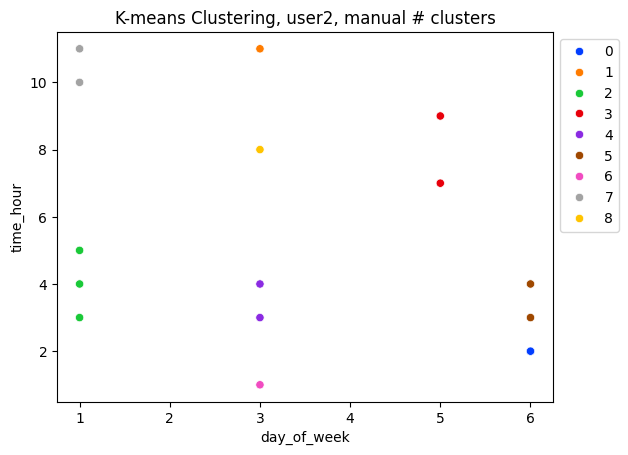

In [295]:
ax = sns.scatterplot(x="day_of_week", y="time_hour", hue=y, data=user2, palette='bright')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('K-means Clustering, user2, manual # clusters')
plt.show()

In [296]:
# gaussian mixture model, eyeballing n clusters

In [297]:
gmm = GaussianMixture(n_components=12)
y = gmm.fit_predict(user2)

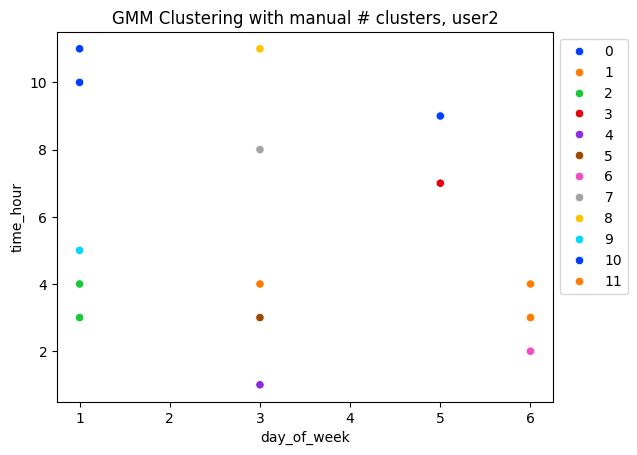

In [298]:
ax = sns.scatterplot(x="day_of_week", y="time_hour", hue=y, data=user2, palette='bright')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('GMM Clustering with manual # clusters, user2')
plt.show()

In [299]:
# results looking similar between the two with gmm performing slightly better, visually clusters are looking good
# next, i'll compare the two after finding the optimal number of clusters using silhouette score

In [300]:
# mean norm
# i chose to calculate the optimal number of clusters after normalizing to ensure that differing locations are adequately accounted for 
# however, i use the un-normalized version of the dataset to actually cluster, since i found that the model tends to overfit on location if i feed it the normalized version
min_max_scaler = preprocessing.MinMaxScaler()
user2_minmax_norm = pd.DataFrame(min_max_scaler.fit_transform(user2.values))

In [301]:
# kmeans first
s_scores = []
max_clusters = len(user2_minmax_norm)

for i in range(2, max_clusters+1):
  y = KMeans(n_clusters = i).fit_predict(user2_minmax_norm)
  s_scores.append(silhouette_score(user2_minmax_norm, y, metric = 'euclidean', sample_size=len(user2_minmax_norm)))

for i, val in enumerate(s_scores):
  if val == max(s_scores):
    optimal_n_clusters = i+2
    break

print(s_scores)
print(optimal_n_clusters)

/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

[0.17596894210386962, 0.2425166829633847, 0.2861469864458311, 0.32306693985337664, 0.31109516805350534, 0.38256672382634876, 0.37924326477275433, 0.37462258171820995, 0.370184346078664, 0.36848237506897946, 0.3643239133316288, 0.2873555930353366, 0.2775516714667091, 0.14705882352941177, 0.11764705882352941, 0.11764705882352941]
7


/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


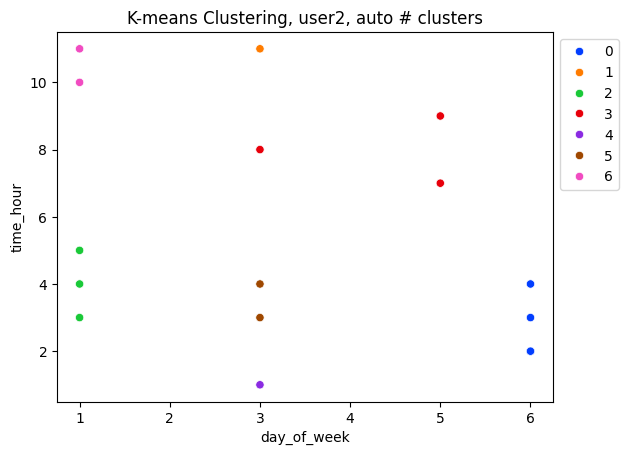

In [302]:
clusters_kmeans = KMeans(n_clusters = optimal_n_clusters).fit_predict(user2)
ax2 = sns.scatterplot(x="day_of_week", y="time_hour", hue=clusters_kmeans, data=user2, palette='bright')
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.title('K-means Clustering, user2, auto # clusters')
plt.show()

In [303]:
# now let's try with gmm
s_scores = []
max_clusters = len(user2_minmax_norm)

for k in range(2, max_clusters+1):
  gmm = GaussianMixture(n_components=k)
  y = gmm.fit_predict(user2_minmax_norm)
  s_scores.append(silhouette_score(user2_minmax_norm, y, metric='euclidean'))

for i, val in enumerate(s_scores):
  if val == max(s_scores):
    optimal_n_clusters = i+2
    break

print(s_scores)
print(optimal_n_clusters)

[0.11907133465480679, 0.18196643920726158, 0.18523887377482984, 0.22150234720213685, 0.33015491271759667, 0.3032087626326425, 0.2985760511310981, 0.3199546012052535, 0.37292061070852556, 0.3658948349782491, 0.36432391333162883, 0.2873555930353365, 0.27755167146670906, 0.14705882352941177, 0.11764705882352941, 0.11764705882352941]
10


/Users/allisongeary/tdl/tdlvenv/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [304]:
gmm = GaussianMixture(n_components=optimal_n_clusters)
y = gmm.fit_predict(user2)

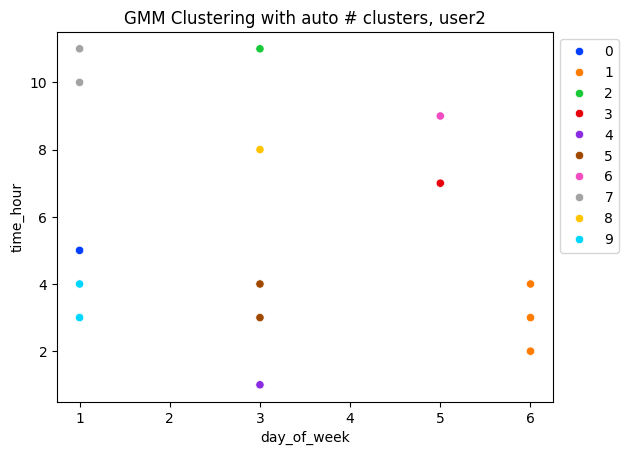

In [305]:
ax = sns.scatterplot(x="day_of_week", y="time_hour", hue=y, data=user2, palette='bright')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('GMM Clustering with auto # clusters, user2')
plt.show()

In this option, the GMM performed the most coherently (i.e. it clustered temporally similar events together, also taking into account location and treatment). To apply this option in the app itself, I will find the centroid of each cluster and calculate one standard deviation from this centroid. When the user's information falls into the approximate centroid of a cluster, the app will send a location at the end of the time range available to the cluster. This will ensure that users don't receive duplicate notifications in a short period of time and that users only recieve notifications for tasks that are actually repeated. In a live version of the app where data is being updated frequently, this model can be updated periodically in the background.  

In [306]:
# finding the centroid, 1 std range for each cluster
cluster_stats = pd.DataFrame({'cluster': [], 'means': [], 'stds': [], 'mins': [], 'maxes': []})
user2['cluster_label'] = y

/var/folders/zm/0ny9q8ys0651cg8p_vw8n88c0000gn/T/ipykernel_40958/1985613540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user2['cluster_label'] = y


In [308]:
for i in range(0, len(gmm.means_)):
   user2_limited = user2[user2['cluster_label']==i]
   user2_limited = user2_limited[['time_hour', 'day_of_week', 'user_id', 'official_diagnosis',
       'diagnosis_Anxiety', 'diagnosis_Neither', 'medication_No medication',
       'medication_Zoloft 75mg', 'medication_sertraline 200mg',
       'location_ Bradley Hall', 'location_ Helen c white library',
       'location_ Holland Hall', 'location_ Old Main',
       'location_ Skoglund Athletic Building', 'location_ Stav Hall',
       'location_ Thomson Building', 'location_ Van Hise',
       'location_ Van Hise Hall', 'location_ Van Hise hall',
       'location_ Van Vleck hall', 'location_ brogden',
       'location_ college library', 'location_ dejope',
       'location_ dejope dorm', 'location_ dejope hall',
       'location_ dejope residence hall',
       'location_ educational sciences building', 'location_ elvehjem',
       'location_ engineering hall', 'location_ humanities',
       'location_ ingraham hall', 'location_ memorial union',
       'location_ paterson', 'location_ social sciences building',
       'location_ stock pavilion', 'location_ study waisman center',
       'location_ sullivan', 'location_ sullivan hall', 'location_ the bus',
       'location_ trader joes', 'location_ walgreens',
       'location_ walk from bus to dorm', 'location_ west high school']]
   if len(user2_limited) > 1:
      cluster_stats_limited = pd.DataFrame({'cluster': [i], 'means': [user2_limited.mean().tolist()], 'stds': [user2_limited.std().tolist()], 'mins': [(user2_limited.mean()-user2_limited.std()).tolist()], 'maxes': [(user2_limited.mean()+user2_limited.std()).tolist()]})
   else:
      cluster_stats_limited = pd.DataFrame({'cluster': [i], 'means': [user2_limited.mean().tolist()], 'stds': [[0] * len(user2_limited.mean().tolist())], 'mins': [user2_limited.mean().tolist()], 'maxes': [user2_limited.mean().tolist()]})
   cluster_stats = pd.concat([cluster_stats, cluster_stats_limited])
cluster_stats


,cluster,means,stds,mins,maxes
0,0.0,"[5.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[5.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
0,1.0,"[2.6, 6.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.8944271909999159, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.7055728090000843, 6.0, 2.0, 1.0, 1.0, 0.0, ...","[3.494427190999916, 6.0, 2.0, 1.0, 1.0, 0.0, 0..."
0,2.0,"[11.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[11.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,..."
0,3.0,"[7.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[7.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
0,4.0,"[1.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
0,5.0,"[3.5, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.7071067811865476, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7928932188134525, 3.0, 2.0, 1.0, 1.0, 0.0, ...","[4.207106781186548, 3.0, 2.0, 1.0, 1.0, 0.0, 0..."
0,6.0,"[9.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[9.0, 5.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
0,7.0,"[10.5, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[0.7071067811865476, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.792893218813452, 1.0, 2.0, 1.0, 1.0, 0.0, 0...","[11.207106781186548, 1.0, 2.0, 1.0, 1.0, 0.0, ..."
0,8.0,"[8.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[8.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
0,9.0,"[3.5, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.7071067811865476, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7928932188134525, 1.0, 2.0, 1.0, 1.0, 0.0, ...","[4.207106781186548, 1.0, 2.0, 1.0, 1.0, 0.0, 0..."


In [309]:
cluster_stats.to_csv('clustering_results.csv')